In [17]:
# import all modules
import numpy as np
import PIL.Image as Image
import libtiff
from matplotlib import pyplot as plt
import matplotlib
from skimage import io
from PRIS import SingleObs
import copy
import drawnow

# Construct obseration operator

In [2]:
# construct observation operator.
 # load psf matrix
dpath = './test_data/psf.tif';
psf = io.imread(dpath)


# Load observation

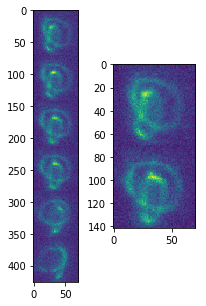

In [3]:
# load observation
data_path = './test_data';
f = 'obsStack.tif';
fov = io.imread(data_path + '/' + f)
fov.shape
plt.figure(figsize=(5,5));
plt.subplot(131)
plt.imshow(fov[[1,3,5,6,10,15],:,:].reshape(6*fov.shape[1],fov.shape[2]))
blur1 = fov[1,:,:];
blur2 = fov[5,:,:];

blur = np.concatenate([blur1, blur2]).reshape(2*71,71);
plt.subplot(132)
plt.imshow(blur)

# Decide candidates

In [4]:
# decide candidates 
range_ind0 = np.arange(-30,25)
range_ind1 = np.arange(12,62,2)
range_ind2 = np.arange(10,60,2)
candidate_locs = list()
for i0 in range_ind0:
    for i1 in range_ind1:
        for i2 in range_ind2:
            candidate_locs.append([i0,i1,i2])

# Construct sensing matrix

In [5]:
# construct sensing matrix
    # dependencies: candidates, observation operator.
    # yield: sensing matrix
    # method: loop over all candidates and record the corresponding observations.
a = SingleObs()
a.psf = np.copy(psf)
a.psfz0 = 106
a.debug = False
a.imsize = blur1.shape
a.edge_padding = True
A = np.ndarray([blur.shape[0]*blur.shape[1], len(candidate_locs)+1])
A.shape
for count, loc in enumerate(candidate_locs):
#for count, loc in enumerate([[0,10,10],[10,10,10]]):
    
    loc1 = np.copy(loc); loc1[0] = np.copy(loc[0])-8
    loc2 = np.copy(loc); loc2[0] = np.copy(loc[0])+8
    a.location = loc1
    a.single_obs()
    a1 = a.obs.ravel()
    
    a.location = loc2
    a.single_obs()
    a2 = a.obs.ravel()
    
    A[:,count] = np.concatenate([a1.ravel(),a2.ravel()]).ravel()
A[:,len(candidate_locs)] = 1

# Define LinBreg

In [41]:
class LinBreg:
    import time
    def __init__(self, A, x, b):
        # solve for x from Ax = b.
        self.A = A # sensing matrix.
        self.x = x # coefficient vector for the pool of candidates.
        self.b = b # observation vector.
        self.mu = np.mean(self.b.ravel())  # shrinkage threshold.
        self.cumerr = np.zeros(self.x.shape)
        self.flag_stop = False # flag to stop optimization iteration
        self.opts = False # debug flag
        self.opts = False # debug flag
        self.maxit = 10 # maximum iteration steps
        self.stepsize = 10 # step size
        self.flag_positivity = True
        self.debug = False
        self.debug_it_int = 2
        self.iterations = list()

    def getready(self):
        if self.debug is True:
            import os
            # define the name of the directory to be created
            path = "./debug_output"
            try:  
                os.mkdir(path)
            except OSError:  
                print ("Creation of the directory %s failed" % path)
            else:  
                print ("Successfully created the directory %s " % path)

    def shrink(self):
        self.cumerr[np.where(self.cumerr > self.mu)] -= self.mu
        self.cumerr[np.where(self.cumerr < -self.mu)] += self.mu
        
    def go(self):
        t1 = time.time()
        it_count = 0
        self.iterations.append(it_count)
        if self.debug is True:
            plt.figure(figsize=(10, 10))
            fig, ax = plt.subplots()
        
        while self.flag_stop is False:
            er = self.b - np.dot(self.A, self.x)
            erpj = np.dot(er, self.A)
            self.cumerr += erpj
            if self.flag_positivity is True: self.cumerr[np.where(self.cumerr < 0)] = 0
            self.shrink()
            self.x = self.stepsize * self.cumerr
            it_count += 1
            # determin stop or not
            if it_count > self.maxit: self.flag_stop = True

            # output to check under debug mode
            if self.debug is True:
                if np.remainder(it_count, self.debug_it_int) == 0:
                    print('intermediate output it#'+ str(it_count))
                    temp = np.mean(self.x[0:34375].reshape(range_ind0.size,range_ind1.size,range_ind2.size),axis=0)
                    im = Image.fromarray(temp)
                    matplotlib.image.imsave('./debug_output/name'+str(it_count)+'.png', temp)
                    plt.subplot(211)
                    plt.plot(np.arange(1,10),np.arange(4,13))
                    plt.plot(np.arange(1,10),np.arange(4,13))
                    plt.savefig('./debug_output/plot'+str(it_count)+'.png')

# Recovery

Creation of the directory ./debug_output failed
intermediate output it#2
intermediate output it#4
intermediate output it#6
intermediate output it#8
intermediate output it#10


<Figure size 720x720 with 0 Axes>

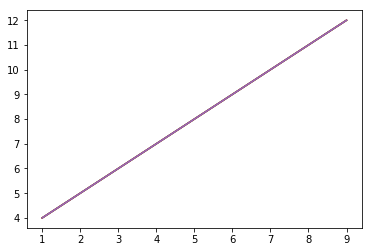

In [43]:
# recover
    # input sensint matrix, and observation; 
    # yield: recovered vector
    # use scikit learn lasso solver
import time
a = LinBreg(A,np.zeros(A.shape[1]),blur.ravel())
a.debug = True
a.getready()
a.go()

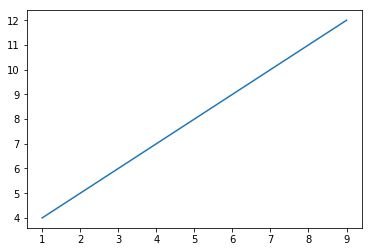

In [38]:
plt.plot(np.arange(1,10),np.arange(4,13))
plt.show()

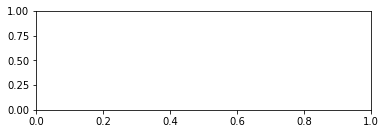

In [18]:
plt.subplot(211)
temp = np.mean(a.x[0:34375].reshape(range_ind0.size,range_ind1.size,range_ind2.size),axis=0)
im = Image.fromarray(temp)
matplotlib.image.imsave('name.png', temp)


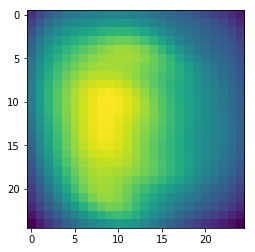

In [76]:
plt.imshow(np.mean(l,axis=0))

In [108]:
for x in np.arange(1,10):
    print(str(x) + ',   ' + str(np.remainder(x,2)))

1,   1
2,   0
3,   1
4,   0
5,   1
6,   0
7,   1
8,   0
9,   1


In [66]:
a.x.shape

(34376,)

In [71]:
len(candidate_locs)

34375